In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from fos.util import setup_plot_style
from fos.util import memory


In [3]:

## GLOBAL SETUP
## TODO SET THESE VARS
# dpath = "/glade/u/home/cjreed/data/ukesm"
# plotpath = "/glade/u/home/cjreed/fate-of-snotels/plots/dev"

dpath = "data/ukesm"
plotpath = "plots/dev"

os.makedirs(plotpath, exist_ok=True)
setup_plot_style()


In [4]:
## HELPERS
def read_csvs(dpath: str) -> pd.DataFrame:
  dfs = list()
  for filename in dpath:
      data = pd.read_csv(filename, index_col=None, header=0)
      data['pt'] = filename.stem.split('_')[-1]
      dfs.append(data)
  df = pd.concat(dfs, axis=0, ignore_index=True)
  df = df.rename(columns={'Unnamed: 0': 'wyear'})
  return df


@memory.cache
def get_data(dpath: str) -> pd.DataFrame:  
  basins = read_csvs(Path(dpath).glob("wrfb*.csv"))
  pts = read_csvs(Path(dpath).glob("wrfp*.csv"))
  combined_df = pd.merge(pts, basins, how='left', left_on=['pt', 'wyear'], right_on=['pt', 'wyear'], suffixes=('_pt', '_basin'))
  return combined_df


def savefig(name: str):
  plt.savefig(os.path.join(plotpath, name))


def plt_err_hist(dffield, xlabel, ylabel, title, fname):
  plt.clf()
  sns.histplot(dffield)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  savefig(fname)
  plt.show()

def plt_year_err(data, title, xlab, ylab, fname):
  plt.clf()
  mean_data = data.mean()
  std_data = data.std()
  mean_data.plot()
  plt.fill_between(mean_data.index, mean_data - std_data, mean_data +  std_data, color="b", alpha=0.2);
  plt.ylabel(ylab)
  plt.xlabel(xlab)
  plt.title(title)
  savefig(fname)
  plt.show()
  
def plot_relation(df, x, y, title, fname, c='wyear', colormap='viridis'):
  plt.clf()
  df.plot.scatter(x=x, y=y, c=c, colormap=colormap, title=title)
  plt.gca().axline((0, 0), slope=1)
  savefig(fname)
  plt.show()


In [5]:
# read in the data from dpath
df = get_data(dpath)
df.head()

orig_len = len(df)
# clean the data
df.dropna(inplace=True)
new_len = len(df)
print(f"dropped {orig_len - new_len}/{orig_len} rows with NaNs")


dropped 5616/96408 rows with NaNs


In [7]:
# Experiment variables

# Use the ratio per location from 1980-Present to determine the location-based correction factor
max_year = 2020

# Experiment 1
### Predict Snotel WRF Pt as Basin Value

The first baseline experiment examines predicting the Peak SWE Basin values for each year using the corresponding Peak SWE Pt values (note that the Pt values tend to overpredict the Basin values).

Unless otherwise noted, "Pt" is the average value at a particular WRF cell (e.g. 3km^2 or 9km^2), corresponding to a point of interest (e.g. a snotel)
and "Basin" is the average of all cells in an entire HUC 6 basin.


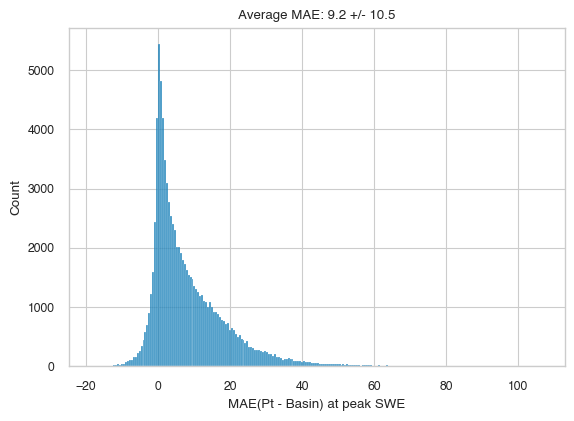

<Figure size 640x440 with 0 Axes>

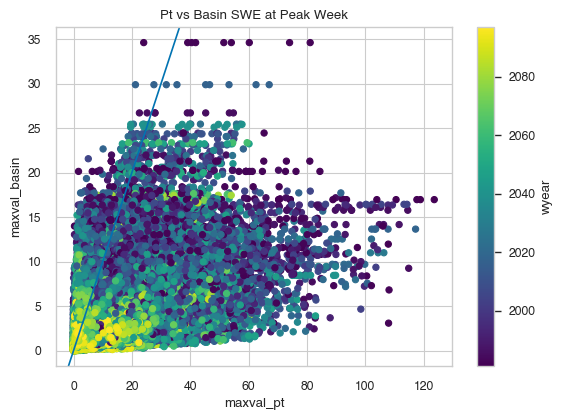

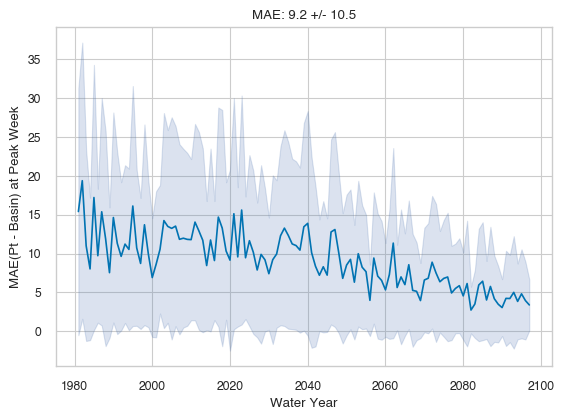

,wyear,maxval_pt,maxdate_pt,maxarg_pt,pt,maxval_basin,maxdate_basin,maxarg_basin,pt_basin_diff,abs_pt_basin_diff
0,1981,15.725918,1981-03-24,174,GreenMountain503,1.705744,1981-03-21,171.0,14.020174,14.020174
1,1982,16.584675,1982-02-20,142,GreenMountain503,2.141873,1982-02-08,130.0,14.442802,14.442802
2,1983,5.379165,1983-01-25,116,GreenMountain503,0.762138,1983-01-21,112.0,4.617027,4.617027
3,1984,3.791908,1984-02-02,124,GreenMountain503,0.363828,1984-01-30,121.0,3.428081,3.428081
4,1985,17.839478,1985-03-02,152,GreenMountain503,2.313212,1984-12-09,69.0,15.526266,15.526266


In [25]:

###############################
# Simple baseline: peak SWE vs 
#####################

# What is the difference between the pt and basic values at peak SWE?
df['pt_basin_diff'] = (df['maxval_pt'] - df['maxval_basin'])
df['abs_pt_basin_diff'] = df['pt_basin_diff'].abs()
total_mae = df['pt_basin_diff'].abs().mean()
total_mae_std = df['pt_basin_diff'].abs().std()

## Plotting error histogram ##  
plt_err_hist(df['pt_basin_diff'], 'MAE(Pt - Basin) at peak SWE', 'Count', f'Average MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', '1-err_hist.png')

# scatterplot of pt vs basin
plot_relation(df, 'maxval_pt', 'maxval_basin', 'Pt vs Basin SWE at Peak Week', '1-maxval_pt_vs_maxval_basin.png')

# error by year
plt_year_err(df.groupby('wyear')['abs_pt_basin_diff'], f'MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', 'Water Year', f'MAE(Pt - Basin) at Peak Week', f'1-err_by_year.png')

# take a look at the new columns
df.head()


# Experiment 2
### Predict Snotel WRF Pt as Basin Value, but mean correct the WRF Pt value using relationship from 1979-2020 at the given location



/var/folders/r7/r_pm2fhn7jd24ryy912xpl300000gn/T/ipykernel_33947/2479874081.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corr_factor = df[df.wyear <= max_year].groupby('pt').mean()['pt_basin_diff']


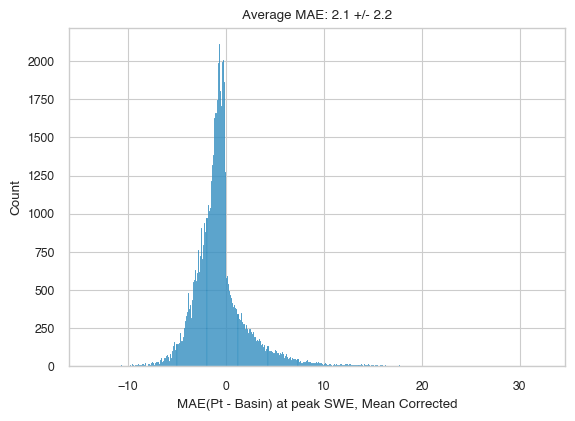

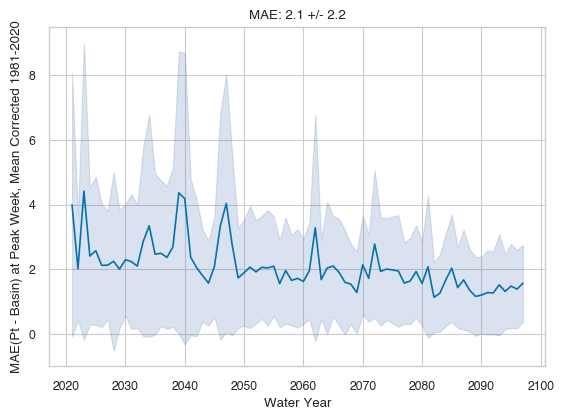

<Figure size 640x440 with 0 Axes>

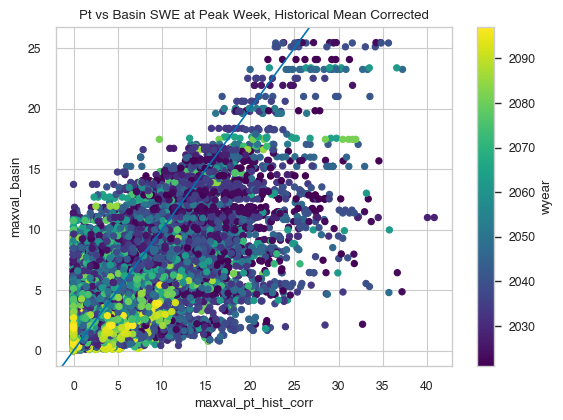

,wyear,maxval_pt,maxdate_pt,maxarg_pt,pt,maxval_basin,maxdate_basin,maxarg_basin,pt_basin_diff,abs_pt_basin_diff,pt_basin_diff_corr_factor,maxval_pt_hist_corr,pt_basin_diff_corr,abs_pt_basin_diff_corr
40,2021,16.187084,2020-11-13,43,GreenMountain503,2.462765,2020-10-10,9.0,13.724319,13.724319,8.589016,7.598068,5.135303,5.135303
41,2022,2.754417,2022-09-14,348,GreenMountain503,0.811663,2022-09-14,348.0,1.942754,1.942754,8.589016,0.000000,-0.811663,0.811663
42,2023,12.913355,2022-11-28,58,GreenMountain503,1.704028,2022-10-28,27.0,11.209327,11.209327,8.589016,4.324339,2.620312,2.620312
43,2024,9.835692,2024-09-28,363,GreenMountain503,1.806736,2024-09-11,346.0,8.028956,8.028956,8.589016,1.246676,-0.560060,0.560060
44,2025,9.779882,2024-10-01,0,GreenMountain503,1.717345,2025-09-23,357.0,8.062537,8.062537,8.589016,1.190866,-0.526479,0.526479


In [26]:

############################################################################################################  
## Simple mean correcting
############################################################################################################

# find the mean difference between pt and basin for each location in the past years until max_year
corr_factor = df[df.wyear <= max_year].groupby('pt').mean()['pt_basin_diff']

# apply the correction factor to the pt values
df = pd.merge(df, corr_factor, how='left', left_on='pt', right_on='pt', suffixes=('', '_corr_factor'))

# calculate the new error by subtracting the corrected pt from the previous difference
df['maxval_pt_hist_corr'] = df['maxval_pt'] - df['pt_basin_diff_corr_factor']
# do not allow maxval_pt_hist_corr to be negative:
df.loc[df['maxval_pt_hist_corr'] < 0, 'maxval_pt_hist_corr'] = 0


df['pt_basin_diff_corr'] = df['maxval_pt_hist_corr'] - df['maxval_basin']
df['abs_pt_basin_diff_corr'] = df['pt_basin_diff_corr'].abs()
df_past_max = df[df.wyear > max_year]

total_mae = df_past_max["abs_pt_basin_diff_corr"].mean()
total_mae_std = df_past_max["abs_pt_basin_diff_corr"].std()

plt_err_hist(df_past_max['pt_basin_diff_corr'], 'MAE(Pt - Basin) at peak SWE, Mean Corrected', 'Count', f'Average MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', '2-err_hist_mean_corr.png')  
plt_year_err(df_past_max.groupby('wyear')['abs_pt_basin_diff_corr'],f'MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', 'Water Year', f'MAE(Pt - Basin) at Peak Week, Mean Corrected 1981-{max_year}', f'2-err_by_year_mean_corr-{max_year}.png')
plot_relation(df_past_max, 'maxval_pt_hist_corr', 'maxval_basin', 'Pt vs Basin SWE at Peak Week, Historical Mean Corrected', f'2-maxval_pt_vs_maxval_basin_mean_corr-{max_year}.png')

df_past_max.head()

# Experiment 3
### Predict Historical Basin Value (1979-2020) for all future years (2021-2100)

/var/folders/r7/r_pm2fhn7jd24ryy912xpl300000gn/T/ipykernel_33947/299943507.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  basin_avg_val = df[df.wyear <= max_year].groupby('pt').mean()['maxval_basin']


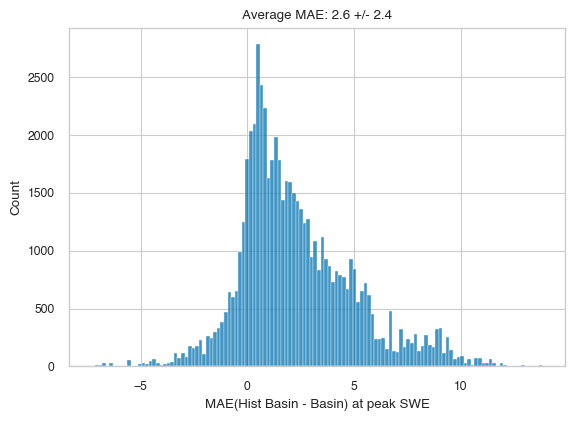

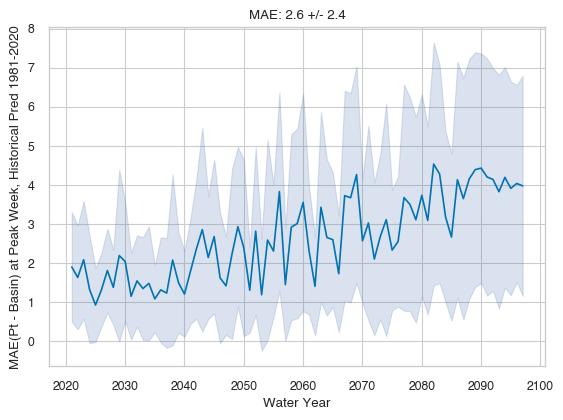

<Figure size 640x440 with 0 Axes>

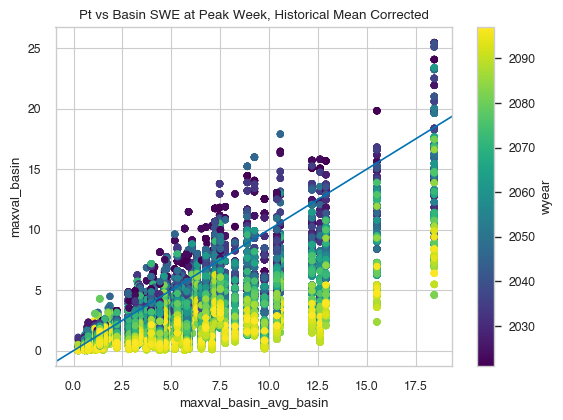

In [27]:
# get the average basin value for each location in the past years until max_year
basin_avg_val = df[df.wyear <= max_year].groupby('pt').mean()['maxval_basin']
df = pd.merge(df, basin_avg_val, how='left', left_on='pt', right_on='pt', suffixes=('', '_avg_basin'))
df['basin_hist_avg_diff'] = df['maxval_basin_avg_basin'] - df['maxval_basin']
df['abs_basin_hist_avg_diff'] = df['basin_hist_avg_diff'].abs()
df_past_max = df[df.wyear > max_year]
total_mae = df_past_max["abs_basin_hist_avg_diff"].mean()
total_mae_std = df_past_max["abs_basin_hist_avg_diff"].std()

plt_err_hist(df_past_max['basin_hist_avg_diff'], 'MAE(Hist Basin - Basin) at peak SWE', 'Count', f'Average MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', f'3-err_hist_hist-mean-{max_year}.png')
plt_year_err(df_past_max.groupby('wyear')['abs_basin_hist_avg_diff'],f'MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', 'Water Year', f'MAE(Pt - Basin) at Peak Week, Historical Pred 1981-{max_year}', f'3-err_by_year_hist_mean-{max_year}.png')
plot_relation(df_past_max, 'maxval_basin_avg_basin', 'maxval_basin', 'Pt vs Basin SWE at Peak Week, Historical Mean Corrected', f'3-maxval_pt_vs_maxval_basin_hist_mean-{max_year}.png')


# Experiment 4
### Use a rolling window of historical data (e.g. 5 years) to predict current year basin values


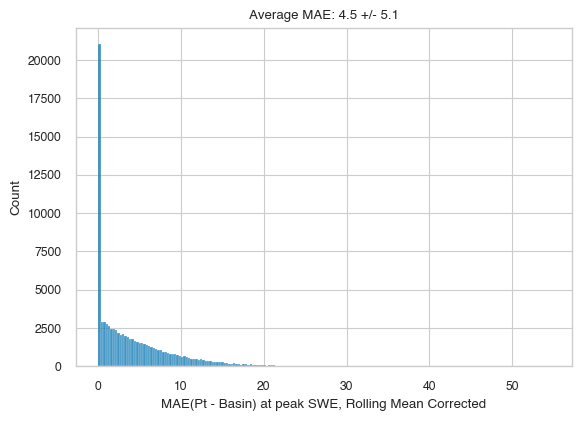

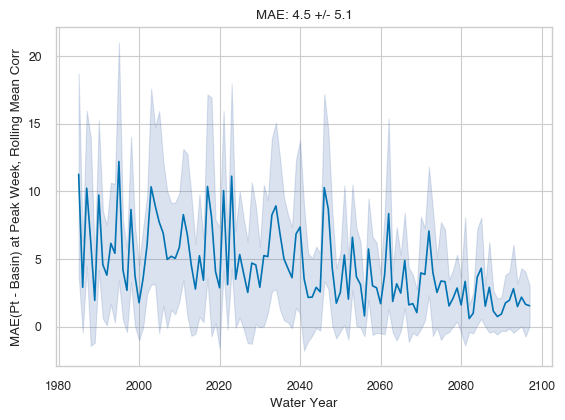

<Figure size 640x440 with 0 Axes>

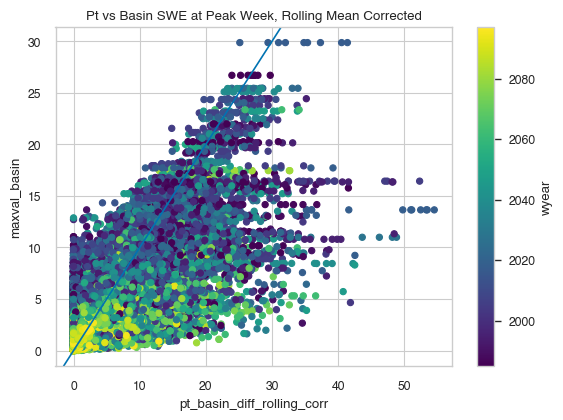

In [28]:
############################################################################################################
## Plotting error using a rolling mean not including the current year
############################################################################################################
nroll = 5
df['pt_basin_diff_rolling'] = df.groupby('pt')['pt_basin_diff'].transform(lambda x: x.rolling(nroll, min_periods=5, closed='right').mean())
df['pt_basin_diff_rolling_corr'] = df['maxval_pt'] - df['pt_basin_diff_rolling']
# do not allow maxval_pt_hist_corr to be negative:
df.loc[df['pt_basin_diff_rolling_corr'] < 0, 'pt_basin_diff_rolling_corr'] = 0
df['abs_pt_basin_diff_rolling_corr'] = df['pt_basin_diff_rolling_corr'].abs()

total_mae = df["abs_pt_basin_diff_rolling_corr"].mean()
total_mae_std = df["abs_pt_basin_diff_rolling_corr"].std()
plt_err_hist(df['pt_basin_diff_rolling_corr'], 'MAE(Pt - Basin) at peak SWE, Rolling Mean Corrected', 'Count', f'Average MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', '4-err_hist_rolling_mean_corr.png')  
plt_year_err(df.groupby('wyear')['abs_pt_basin_diff_rolling_corr'], f'MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', 'Water Year', f'MAE(Pt - Basin) at Peak Week, Rolling Mean Corr', f'4-err_by_year_mean_corr_rolling-{nroll}.png')
plot_relation(df, 'pt_basin_diff_rolling_corr', 'maxval_basin', 'Pt vs Basin SWE at Peak Week, Rolling Mean Corrected', f'4-maxval_pt_vs_maxval_basin_hist_mean-{max_year}.png')


# Experiment 5
### Use data from 1979-2020 to build a linear model for each basin, then use the model to predict future years (2021-2100)


/var/folders/r7/r_pm2fhn7jd24ryy912xpl300000gn/T/ipykernel_1594/1359757283.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lr_res'] = df_test.apply(lambda x: max([0,x['lr'].predict([[x['maxval_pt']]])[0][0]]), axis=1)
/var/folders/r7/r_pm2fhn7jd24ryy912xpl300000gn/T/ipykernel_1594/1359757283.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lr_res_diff'] = df_test['lr_res'] - df_test['maxval_basin']
/var/folders/r7/r_pm2fhn7jd24ryy912xpl300000gn/T/ipykernel_1594/1359757283.py:18: S

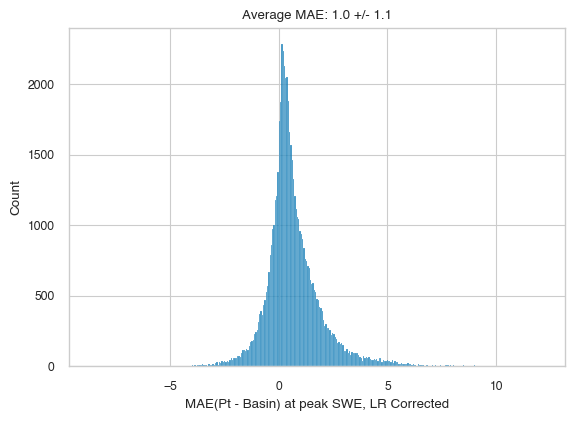

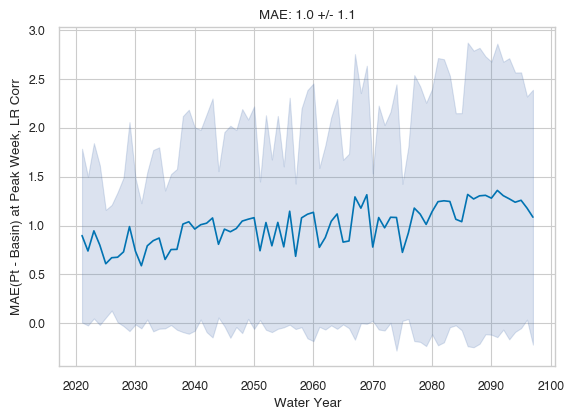

<Figure size 640x440 with 0 Axes>

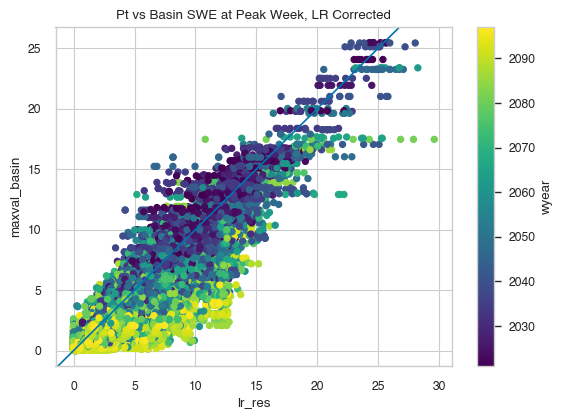

In [18]:
from sklearn.linear_model import LinearRegression
max_year = 2020
df_train = df[df.wyear <= max_year]

# loop over each group and fit a linear regression model
df_group = df_train.groupby("pt")
# df_group_test = df[df.wyear > max_year].groupby("pt")] 
# linear regression for each group

res = df_group.apply(lambda x: LinearRegression().fit(x[['maxval_pt']].values, x[['maxval_basin']].values))
res.name = 'lr'
lr_df = pd.merge(df, res, how='left', left_on='pt', right_on='pt')
df_test = lr_df[lr_df.wyear > max_year]
df_test['lr_res'] = df_test.apply(lambda x: max([0,x['lr'].predict([[x['maxval_pt']]])[0][0]]), axis=1)

# Plot the results and so on
df_test['lr_res_diff'] = df_test['lr_res'] - df_test['maxval_basin']
df_test['abs_lr_res_diff'] = df_test['lr_res_diff'].abs()
total_mae = df_test["abs_lr_res_diff"].mean()
total_mae_std = df_test["abs_lr_res_diff"].std()

plt_err_hist(df_test['lr_res_diff'], 'MAE(Pt - Basin) at peak SWE, LR Corrected', 'Count', f'Average MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', '5-err_hist_lr_corr.png')
plt_year_err(df_test.groupby('wyear')['abs_lr_res_diff'], f'MAE: {total_mae:.1f} +/- {total_mae_std:.1f}', 'Water Year', f'MAE(Pt - Basin) at Peak Week, LR Corr', f'5-err_by_year_lr_corr.png')
plot_relation(df_test, 'lr_res', 'maxval_basin', 'Pt vs Basin SWE at Peak Week, LR Corrected', f'5-maxval_pt_vs_maxval_basin_lr_corr.png')


# Experiment 6
### Build a non-linear model for each basin, then use the model to predict future years (2021-2100)